In [1]:
# date: 1/4/2022
# author: Ziwen
# task: summarize imputed Varaset home and work locations
import os, sys, gc
import pandas as pd
import numpy as np
import yaml
import os
import glob
import ipystata

from google.cloud import storage
from google.cloud import bigquery

path = os.path.expanduser('~')
# set up env credential variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path + '/Dropbox/Amenity/source/analysis/veraset_gravy_gps_sample/firm-exit-3608acd14b06.json'
client = bigquery.Client()

import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Distribution of pings from mon-sun
Before everything, just check the pings dropped at home - the distribution from monday to sunday

In [2]:
# count pings at home by day of week, and hour of day
default_dataset = 'firm-exit.veraset_visits'
job_config_count = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     default_dataset=default_dataset)

query_count = f'''
    with raw_ping as
    (select
    -- necessary variables and calculation
        caid as caid, 
        extract(hour from datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as hofd,
        format_datetime('%A', datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as dofw,
        substr(geo_hash, 1, 7) as geohash7     
    from `ping_ca_01`
    ), home_raw_ping as
    -- select raw pings at home of IDs we were able to identify home locations
    (select
        raw_ping.caid as caid,
        hofd as hofd,
        dofw as dofw
    from raw_ping
    inner join `home_id_loc`
    on `home_id_loc`.`caid` = raw_ping.caid and `home_id_loc`.`geohash7` = raw_ping.geohash7
    )
    select 
        dofw,
        hofd,
        count(caid) as count
    from home_raw_ping
    group by dofw, hofd
'''

query_job_count = client.query(query_count, job_config=job_config_count)
query_job_count.result() 

In [3]:
dist = query_job_count.to_dataframe()
dist

,dofw,hofd,count
0,Friday,16,67769762
1,Friday,22,67637548
2,Monday,13,40565085
3,Friday,13,46273565
4,Wednesday,9,42388000
...,...,...,...
163,Saturday,21,61123172
164,Thursday,8,51695699
165,Tuesday,22,65625362
166,Thursday,17,45880213


In [10]:
dist_dofw = dist.groupby('dofw')['count'].agg('sum')

day = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
dist_dofw = dist_dofw.reindex(day)

<BarContainer object of 7 artists>

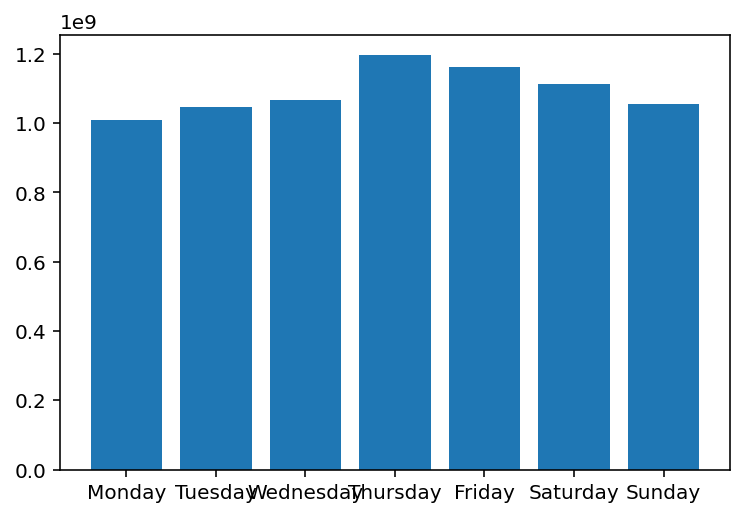

In [14]:
plt.bar(day, dist_dofw)

In [15]:
dist_hofd = dist.groupby('hofd')['count'].agg('sum')

hour = np.arange(24)

<BarContainer object of 24 artists>

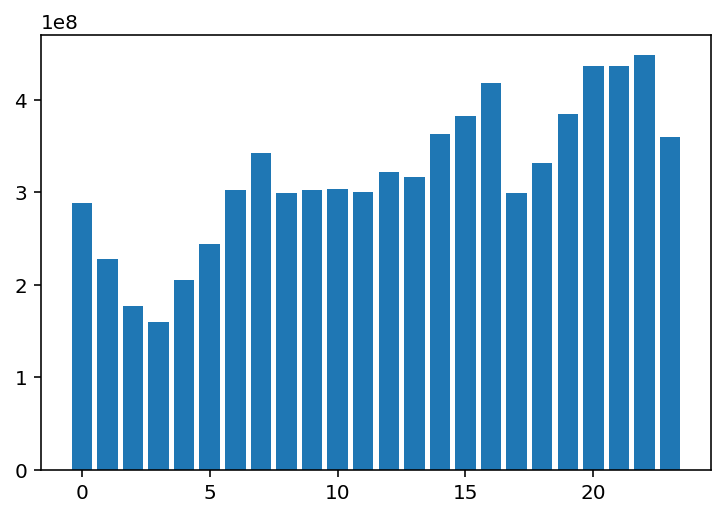

In [16]:
plt.bar(hour, dist_hofd)

## Select, collapse data to device-hour level
1. select raw pings for those devices at their identified home/work geohash7 regions.   
   this is done by selecting unique ID from `time_converted_raw_ping' with certain conditions.
2. Collapse data to device-hour level, aka to count the number of pings in each geohash7 region

In [3]:
# set up default working dataset
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_device_hour'
job_config = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

In [6]:
# upload home locations to BQ
destination_table = 'firm-exit.veraset_visits.home_id_loc'


# first need to upload home work locations to BQ from local
file_path = path+'/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/varaset_home_locations.csv'
table_id = destination_table
job_config_upload = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV, skip_leading_rows=1, autodetect=True, write_disposition='WRITE_TRUNCATE',
    )

with open(file_path, "rb") as source_file:
    job_upload = client.load_table_from_file(source_file, table_id, job_config=job_config_upload)

job_upload.result()  # Waits for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 4202403 rows and 14 columns to firm-exit.veraset_visits.home_device_hour


In [7]:
# load work locations to BQ
destination_table = 'firm-exit.veraset_visits.work_id_loc'

file_path = path+'/Dropbox/Amenity/data/analysis/veraset_gravy_gps_sample/varaset_work_locations.csv'
table_id = destination_table
job_config_upload = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV, skip_leading_rows=1, autodetect=True, write_disposition='WRITE_TRUNCATE',
    )

with open(file_path, "rb") as source_file:
    job_upload = client.load_table_from_file(source_file, table_id, job_config=job_config_upload)

job_upload.result()  # Waits for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 3991587 rows and 18 columns to firm-exit.veraset_visits.work_device_hour


In [6]:
# select, collapse to device-hour level
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_device_hour'
job_config_select_collapse = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_select_collapse = f'''
    with raw_ping as
    (select
    -- necessary variables and calculation
        caid as caid, 
        id_type as id_type,
        extract(hour from datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as hofd,
        format_datetime('%A', datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as weekday,
        substr(geo_hash, 1, 7) as geohash7     
    from `ping_ca_01`
    -- the last week excluded due to the lack of data on 10-30 and 10-31
    where cast(datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour) as datetime)<cast('2021-10-25 00:00:00' as datetime)
    ), home_raw_ping as
    -- select raw pings at home of IDs we were able to identify home locations
    (select
        raw_ping.caid as caid,
        id_type as id_type,
        hofd as hofd,
        weekday as weekday,
        raw_ping.geohash7 as geohash7
    from raw_ping
    inner join `home_id_loc`
    on `home_id_loc`.`caid` = raw_ping.caid and `home_id_loc`.`geohash7` = raw_ping.geohash7
    ), device_weekday_hour as
    (select 
        caid as caid,
        hofd as hofd,
        weekday as weekday,
        count(caid) as num_records_home
    from home_raw_ping
    -- group by device-weekday-hour level
    group by caid, weekday, hofd
    ), any_type_geohash as
    (select
        caid as caid,
        id_type as id_type, 
        geohash7 as geohash7,
        row_number() over(partition by caid) as rn
    from home_raw_ping
    ), device_type_geohash as
    (select
        * 
    from any_type_geohash where rn = 1
    -- whichever, just need that id_type and geohash region
    )
    select 
        device_weekday_hour.*, 
        device_type_geohash.id_type,
        device_type_geohash.geohash7
    from device_type_geohash
    inner join device_weekday_hour
    on device_type_geohash.caid = device_weekday_hour.caid
'''

query_job_select_collapse = client.query(query_select_collapse, job_config=job_config_select_collapse)
query_job_select_collapse.result() 

In [23]:
# export to gcs and download
project = "firm-exit"
dataset_id = "veraset_visits"
table_id = "home_device_hour"

destination_uri = "gs://{}/{}".format('varaset_temp', "home_device_hour*.csv")
dataset_ref = bigquery.DatasetReference(project, dataset_id)
table_ref = dataset_ref.table(table_id)

extract_job = client.extract_table(
    table_ref,
    destination_uri,
    # Location must match that of the source table.
    location="US",
)  # API request
extract_job.result()  # Waits for job to complete.

print(
    "Exported {}:{}.{} to {}".format(project, dataset_id, table_id, destination_uri)
)

Exported firm-exit:veraset_visits.home_device_hour to gs://varaset_temp/home_device_hour*.csv


from here the work on summarizing raw pings dropped at home locations is transported to my colab.  
Link here ``https://colab.research.google.com/drive/1e5Qy6-cO077Ww9lw7Q63arJTd9XcHObK?usp=sharing``

Note 1/21/2022: I devided to use stata with a subsample instead of using colab with (nearly) full sample. Stata is more proficient with summary graphs and weights. It also saves money since mounting gcs would cost storage fees.

In [7]:
# 1/21/2022 revision - weights
# downsample so can analyze in stata
# downsample using the id in the order of home_id_loc
default_dataset = 'firm-exit.veraset_visits'
job_config_downsample = bigquery.QueryJobConfig(default_dataset=default_dataset)

query_downsample = f'''
    with caid_num as
    -- generate numerical id for caid
    (select
        caid as caid,
        row_number() over () as device_id
    from `home_id_loc`
    ), merge_coverage as
    (select 
        `home_device_hour`.`caid` as caid,
        hofd,
        case 
            when (weekday = 'Monday') then 1
            when (weekday = 'Tuesday') then 2
            when (weekday = 'Wednesday') then 3
            when (weekday = 'Thursday') then 4
            when (weekday = 'Friday') then 5
            when (weekday = 'Saturday') then 6
            when (weekday = 'Sunday') then 7
        end as dofw,
        num_records_home,
        coverage_1 as coverage
    from `home_device_hour`
    inner join `monthly_coverage`
    on `home_device_hour`.`caid` = `monthly_coverage`.`caid`
    ), id_replace as
    -- replace string id with num id, easier to process
    (select
        merge_coverage.hofd,
        merge_coverage.dofw, 
        merge_coverage.num_records_home,
        merge_coverage.coverage,
        caid_num.device_id
    from merge_coverage
    inner join caid_num
    on merge_coverage.caid = caid_num.caid
    )
    select 
        *,
    from id_replace
    order by device_id
    limit 10000000
'''

query_job_downsample = client.query(query_downsample, job_config=job_config_downsample)
query_job_downsample.result() 


In [8]:
downsample = query_job_downsample.to_dataframe()
downsample.to_csv(path+'/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/home_device_hour_sample.csv', sep=',', mode='w')

from here switch to stata. Turns out Stata is much more proficient in making summary plots.

See home_device_hour.do in the same directory

## Aggregate home pings to home hours
### formerly called home hours

here for those pings at the imputed home locations, I aggregate them into hours at home instead of looking directly at the number of raw pings. The problem of the number of raw pings is that you can stay at home for a long time and not move too much, then there would not be many pings (weekends), but you can also stay at home for a short time but move a lot, then there would be many pings (weekdays). Aggregating into hours avoids that issue.  

Two methods:  
1. as long as there is a raw ping in an hour, count that as a home hour regardless of the number of pings  
   this does not require any new indicator -- as long as that hour exists in the data, that's a home hour
2. there needs not only a ping, but also high coverage in an hour.  
   this way it's likely at night there are not too many pings, so nighttime home hours are fewer than daytime home hours.


In [6]:
# first need to calculate monthly coverage
# to be merged to home stay data later
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.monthly_coverage'
job_config_monthly_coverage = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_monthly_coverage = f'''
    with monthly_coverage_dup as
    (select
    -- collapse to monthly level by caid, id_type (could be duplicated types)
        caid as caid,
        id_type as id_type,
        sum(coverage_1)/35 as coverage_1,
        sum(coverage_3)/35 as coverage_3,
        sum(coverage_5)/35 as coverage_5,
        sum(coverage_10)/35 as coverage_10
    from `device_coverage`
    group by caid, id_type
    ), monthly_coverage_rank as
    (select
        *,
        row_number() over (partition by caid order by coverage_1 desc) as rn
    from monthly_coverage_dup
    )
    select
        * except (rn)
    from monthly_coverage_rank
    where rn = 1
'''

query_job_monthly_coverage = client.query(query_monthly_coverage, job_config=job_config_monthly_coverage)
query_job_monthly_coverage.result() 

In [8]:
# select, collapse to device-hour level
# one tricky step is to convert time into five minute blocks
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_stay_device_dofw_hofd'
job_config_ping_to_stay = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_ping_to_stay = f'''
    with raw_ping as
    (select
    -- necessary variables and calculation
        caid as caid, 
        timestamp_seconds(300 * div(utc_timestamp - 7*3600, 300)) as PDT_5m,
        format_timestamp("%b-%d-%Y",  datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as date,
        extract(hour from datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as hofd,
        format_datetime('%A', datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour)) as dofw,
        substr(geo_hash, 1, 7) as geohash7     
    from `ping_ca_01`
    -- the last week excluded due to the lack of data on 10-30 and 10-31
    where cast(datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour) as datetime)<cast('2021-10-25 00:00:00' as datetime)
    ), home_raw_ping as
    -- select raw pings at home of IDs we were able to identify home locations
    (select
        raw_ping.caid as caid,
        PDT_5m,
        date,
        hofd,
        dofw
    from raw_ping
    inner join `home_id_loc`
    on `home_id_loc`.`caid` = raw_ping.caid and `home_id_loc`.`geohash7` = raw_ping.geohash7
    ), ping_to_stay as
    -- this primarily deals with the 5-m coverage calculation for every hour in the month
    (select
        caid,
        date,
        dofw,
        hofd,
        case 
            when (count(distinct PDT_5m) >= 3) then 1
            else 0
        end as home_stay_3,
        case 
            when (count(distinct PDT_5m) >= 6) then 1
            else 0
        end as home_stay_6,
        case 
            when (count(distinct PDT_5m) >= 9) then 1
            else 0
        end as home_stay_9
    from home_raw_ping
    -- group by with dofw is fine bc date and dofw is 1-1
    group by caid, date, dofw, hofd
    ), device_stay_dofw_hofd as
    -- aggregate across all weeks in the month, take the sum of stays
    (select
        caid,
        dofw,
        hofd,
        count(caid) as home_stay,
        countif(home_stay_3 = 1) as home_stay_3,
        countif(home_stay_6 = 1) as home_stay_6,
        countif(home_stay_9 = 1) as home_stay_9
    from ping_to_stay
    group by caid, dofw, hofd
    )
    select 
        device_stay_dofw_hofd.caid as caid,
        case 
            when (dofw = 'Monday') then 1
            when (dofw = 'Tuesday') then 2
            when (dofw = 'Wednesday') then 3
            when (dofw = 'Thursday') then 4
            when (dofw = 'Friday') then 5
            when (dofw = 'Saturday') then 6
            when (dofw = 'Sunday') then 7
        end as dofw,
        device_stay_dofw_hofd.hofd,
        device_stay_dofw_hofd.home_stay,
        device_stay_dofw_hofd.home_stay_3,
        device_stay_dofw_hofd.home_stay_6,
        device_stay_dofw_hofd.home_stay_9,
        `monthly_coverage`.coverage_1
    from device_stay_dofw_hofd
    inner join `monthly_coverage`
    on `monthly_coverage`.`caid` = device_stay_dofw_hofd.caid
'''

query_job_ping_to_stay = client.query(query_ping_to_stay, job_config=job_config_ping_to_stay)
query_job_ping_to_stay.result() 

In [11]:
# downsample using the id in the order of home_id_loc
default_dataset = 'firm-exit.veraset_visits'
job_config_downsample = bigquery.QueryJobConfig(default_dataset=default_dataset)

query_downsample = f'''
    with caid_num as
    -- generate numerical id for caid
    (select
        caid as caid,
        row_number() over () as device_id
    from `home_id_loc`
    ), id_replace as
    -- replace string id with num id, easier to process
    (select
        `home_stay_device_dofw_hofd`.`hofd`,
        `home_stay_device_dofw_hofd`.`dofw`,
        `home_stay_device_dofw_hofd`.`home_stay`,
        `home_stay_device_dofw_hofd`.`home_stay_3`,
        `home_stay_device_dofw_hofd`.`home_stay_6`,
        `home_stay_device_dofw_hofd`.`home_stay_9`,
        `home_stay_device_dofw_hofd`.`coverage_1`,
        caid_num.device_id
    from `home_stay_device_dofw_hofd`
    inner join caid_num
    on `home_stay_device_dofw_hofd`.`caid` = caid_num.caid
    )
    select 
        *,
    from id_replace
    order by device_id
    limit 10000000
'''

query_job_downsample = client.query(query_downsample, job_config=job_config_downsample)
query_job_downsample.result() 


In [12]:
downsample = query_job_downsample.to_dataframe()
downsample.to_csv(path+'/Dropbox/Amenity/data/derived/veraset_gravy_gps_sample/veraset/home_stay_device_dofw_hofd_sample.csv', sep=',', mode='w')

## Home Hours aggregated out of pings - summary
### Formerly called Home Stays

from here switch to stata. See home_stay_device_dofw_hofd.do in the same directory

In [ ]:
%%stata -d downsample

## Home Durations
Here for each device, I try to calculate the time and duration of their home stays. The method is simple
1. In raw pings, ordering the data by caid and time stamp is not feasible - gcp cannot do that much of computation for sorting job. Instead, ``lead(geohash7, 1) over (partition by caid order by utc_timestamp)`` gives the geohash7 of the next raw ping, and the condition of extraction is then ``geohash7 != lead.geohash7`` (means the device went a new place) or ``rn()=1`` or ``lead.rn()=1`` (to also extract the start and end of each device's records) or ``geohash7 != lag.geohash7`` (we also need the start of a stay). \[here it's fine that time stamp is not converted to CA local time\] Note here the case of single ping in one geohash7 is still preserved. The next filtering condition deals with that.

2. Then do another *lead* extraction.  
   Now each geohash7 stay should have 2 records (or 1 if just one ping dropped): the start and the end. Another ``lead.geohash7`` should give you the condition ``lead.geohash7=geohash7``. Also take ``lead.timestamp``, as that gives you the start and end time. The one ping cases should be filtered out here given the geohash7 condition, unless it happens to be the ending ping of a device and have the same geohash7 of the starting ping of the next device. Note in any case the last record of a device should not be preserved. So, add condition ``lead.rn()!=1`` (this actually also removes those devices with only 1 ping in total).
   
3. Now each line is a home stay, with start and end time. Good to do whatever analysis.

PS. lead function really is just used to see *this line equals next line or not*

In [7]:
# extract home stays
# it follows the babbling up there ↑
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_start_end'
job_config_extract = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_extract = f'''
    with clean_ping as
    (select
    -- necessary variables and calculation
        caid, 
        utc_timestamp,
        latitude,
        longitude,
        substr(geo_hash, 1, 7) as geohash7,
        row_number() over (partition by caid order by utc_timestamp asc) as rn
    from `ping_ca_01`
    -- the last week excluded due to the lack of data on 10-30 and 10-31
    where cast(datetime_sub(timestamp_seconds(utc_timestamp), interval 7 hour) as datetime)<cast('2021-10-25 00:00:00' as datetime)
    ), raw_ping as
    (select
        caid,
        timestamp,
        lat,
        lon,
        geohash7,
        num_pings_geohash7,
        row_number() over (partition by caid order by timestamp asc) as rn
    from 
    (select 
        caid as caid,
        utc_timestamp as timestamp,
        latitude as lat,
        longitude as lon,
        geohash7 as geohash7,
        rn as rn,
        lead(geohash7, 1) over (partition by caid order by utc_timestamp asc) as next_geohash7,
        lag(geohash7, 1) over (partition by caid order by utc_timestamp asc) as last_geohash7,
        lead(rn, 1 ) over (partition by caid order by utc_timestamp asc) as next_rn, 
            -- if need to add more variables, like the number of pings in a geohash7 region, calculate here.
        count(caid) over (partition by caid, geohash7) as num_pings_geohash7
    from clean_ping
    )
    where (geohash7 != next_geohash7) or (geohash7 != last_geohash7) or (rn = 1) or (next_rn=1) 
    ), stay_start_end as
    (select
        caid,
        start_utc,
        lat,
        lon,
        geohash7,
        num_pings_geohash7,
        end_utc
    from
    (select
        caid,
        timestamp as start_utc,
        lat,
        lon,
        geohash7,
        num_pings_geohash7,
        lead(timestamp, 1 ) over (partition by caid order by timestamp asc) as end_utc,
        lead(geohash7, 1) over (partition by caid order by timestamp asc) as next_geohash7,
        lead(rn, 1 ) over (partition by caid order by timestamp asc) as next_rn
    from raw_ping
    )
    where (geohash7 = next_geohash7) and (next_rn != 1)
    )
    select
        stay_start_end.caid,
        datetime_sub(timestamp_seconds(stay_start_end.start_utc), interval 7 hour) as start_time,
        datetime_sub(timestamp_seconds(stay_start_end.end_utc), interval 7 hour) as end_time,
        stay_start_end.lat,
        stay_start_end.lon,
        stay_start_end.geohash7,
        stay_start_end.num_pings_geohash7,
    from stay_start_end
    inner join `home_id_loc`
    on `home_id_loc`.`caid` = stay_start_end.caid and `home_id_loc`.`geohash7` = stay_start_end.geohash7
'''

query_job_extract = client.query(query_extract, job_config=job_config_extract)
query_job_extract.result() 

In [13]:
# now each line is a home stay, with start and end time at utc_timestamp format
# a bit more processig: 
default_dataset = 'firm-exit.veraset_visits'
destination_table = 'firm-exit.veraset_visits.home_start_end'
job_config_process = bigquery.QueryJobConfig(write_disposition='WRITE_TRUNCATE',
                                     destination=destination_table,
                                     default_dataset=default_dataset)

query_process = f'''
select 
    *
from `home_start_end`
order by caid, start_utc
'''

query_job_process = client.query(query_process, job_config=job_config_process)
query_job_process.result() 
